---

# SPARKLE MOVIE

---


Création d'un système de recommandation de films à partir de la base de données MoviesLens.

## 1. Contexte et objectifs du projet

La base de données **MoviesLens** est un dataset assez connu en apprentissage automatique, aussi bien pour la recherche académique que pour des applications pratiques. Elle est généralement utilisée **pour entraîner des modèles de recommandations, et pour tester et comparer des algorithmes de recommandation, d’analyse de préférences et de filtrage collaboratif**. Nous utilisons pour ce projet la version MovieLens 32M, publiée par le groupe de recherche GroupLens en mai 2024, et qui contient les fichiers suivants:




*   **movies.csv** : les informations sur les films (titre, genres, etc.)
*   **ratings.csv** :  les notes attribuées par les utilisateurs aux films (note de 0.5 à 5 étoiles)
*   **tags.csv** : les tags appliqués par les utilisateurs aux films
*   **links.csv** : des identifiants pour relier les films à d’autres bases (IMDB, TMDb)
*   **README.txt** : des identifiants pour relier les films à d’autres bases (IMDB, TMDb).

Nous travaillons sur ces données en utilisant Spark, car pour de gros volumes de données (32 millions de lignes), cette approche permet de manipuler et d'explorer l'ensemble des données sans risques de crash mémoire. De plus, Spark assure la faisabilité technique des traitements en vue d'entraîner et d'évaluer les systèmes de recommandations. Enfin, il offre toute la flexibilité pour l’industrialisation, la reproductibilité des pipelines et le passage au déploiement à l’échelle réelle (cloud, entreprise).

C’est donc le standard pour traiter, entraîner, et évaluer des systèmes complexes de recommandation sur des jeux de données de cette ampleur.

L'objectif de ce projet est donc de mettre en place des systèmes de recommandations de films, utilisant divers algorithmes, afin de pouvoir suggérer des films aux utilisateurs, d'évaluer la performance des recommandations, puis de discuter des différences/ressemblances entre les diverses approches utilisées.

## 2. Chargement des librairies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## 3. Installation de PySpark et chargement de quelques librairies Spark

In [ ]:
!pip install pyspark
!pip install "pyspark[connect]"
!pip install "pyspark[sql]"
!pip install "pyspark[pandas_on_spark]"
!pip install pyspark[pandas_on_spark] plotly

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark import StorageLevel

## 4. Création d'une session Spark

In [ ]:
spark = SparkSession.builder \
    .appName("MovieLens") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.sql.shuffle.partitions", "8") \
    .master("local[*]") \
    .getOrCreate()

## 5. Chargement des données

In [ ]:
# Connexion à Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Chargement des données dans des DataFrames Spark

movies = spark.read.csv("/content/drive/MyDrive/ml-32m/movies.csv", header=True, inferSchema=True)
ratings = spark.read.csv("/content/drive/MyDrive/ml-32m/ratings.csv", header=True, inferSchema=True)

## 6. Exploration des données

In [ ]:
# Affichage des 10 premières lignes de chaque DataFrame ainsi que des colonnes
#et types de données

movies.show(10)
movies.printSchema()

ratings.show(10)
ratings.printSchema()


+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
+-------+--------------------+--------------------+
only showing top 10 rows

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|     17|   4.0|

### 6.1. Manipulation des données

In [ ]:
# Description

movies.describe().show()
ratings.describe().show()


+-------+-----------------+---------------+--------------------+
|summary|          movieId|          title|              genres|
+-------+-----------------+---------------+--------------------+
|  count|            87585|          87585|               87585|
|   mean|157651.3655192099|           NULL|                NULL|
| stddev|79013.40209904719|           NULL|                NULL|
|    min|                1|         (2019)| We're Comin' To ...|
|    max|           292757|줄탁동시 (2012)|             Western|
+-------+-----------------+---------------+--------------------+

+-------+------------------+------------------+------------------+--------------------+
|summary|            userId|           movieId|            rating|           timestamp|
+-------+------------------+------------------+------------------+--------------------+
|  count|          32000204|          32000204|          32000204|            32000204|
|   mean|100278.50641102163|29318.610121829224|3.5403956487277393|

In [ ]:
# Nombre d'observations, de valeurs nulles et de doublons

from pyspark.sql.functions import col, sum

print("== Structure de movies :")
movies.printSchema()
print(f"== Nombre de lignes : {movies.count()}")
print(f"== Colonnes : {movies.columns}")

print("\n== Valeurs nulles par colonne :")
movies.select([sum(col(c).isNull().cast("int")).alias(c) for c in movies.columns]).show()

print(f"\n== Nombre de doublons (toutes colonnes) : {movies.count() - movies.dropDuplicates().count()}")

print(f"\n======================================================================")

from pyspark.sql.functions import col, sum

print("== Structure de ratings :")
ratings.printSchema()
print(f"== Nombre de lignes : {ratings.count()}")
print(f"== Colonnes : {ratings.columns}")

print("\n== Valeurs nulles par colonne :")
ratings.select([sum(col(c).isNull().cast("int")).alias(c) for c in ratings.columns]).show()

print(f"\n== Nombre de doublons (toutes colonnes) : {ratings.count() - ratings.dropDuplicates().count()}")

== Structure de movies :
root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

== Nombre de lignes : 87585
== Colonnes : ['movieId', 'title', 'genres']

== Valeurs nulles par colonne :
+-------+-----+------+
|movieId|title|genres|
+-------+-----+------+
|      0|    0|     0|
+-------+-----+------+


== Nombre de doublons (toutes colonnes) : 0

== Structure de ratings :
root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)

== Nombre de lignes : 32000204
== Colonnes : ['userId', 'movieId', 'rating', 'timestamp']

== Valeurs nulles par colonne :
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+


== Nombre de doublons (toutes colonnes) : 0


Les deux dataframes n'ont pas le même nombre d'observations: il y a 87 585 observations dans movies et 32 000 204 observations dans ratings. Nous décidons de conserver les films pour lesquels on a toutes les informations (moviesId, title, genres, userId, rating et timestamp). On fera donc une jointure sur la colonne movieId.

In [ ]:
# Jointure

df = movies.join(ratings, on="movieId", how="inner")
df.show(10)

+-------+--------------------+--------------------+------+------+---------+
|movieId|               title|              genres|userId|rating|timestamp|
+-------+--------------------+--------------------+------+------+---------+
|     17|Sense and Sensibi...|       Drama|Romance|     1|   4.0|944249077|
|     25|Leaving Las Vegas...|       Drama|Romance|     1|   1.0|944250228|
|     29|City of Lost Chil...|Adventure|Drama|F...|     1|   2.0|943230976|
|     30|Shanghai Triad (Y...|         Crime|Drama|     1|   5.0|944249077|
|     32|Twelve Monkeys (a...|Mystery|Sci-Fi|Th...|     1|   5.0|943228858|
|     34|         Babe (1995)|      Children|Drama|     1|   2.0|943228491|
|     36|Dead Man Walking ...|         Crime|Drama|     1|   1.0|944249008|
|     80|White Balloon, Th...|      Children|Drama|     1|   5.0|944248943|
|    110|   Braveheart (1995)|    Action|Drama|War|     1|   3.0|943231119|
|    111|  Taxi Driver (1976)|Crime|Drama|Thriller|     1|   5.0|944249008|
+-------+---

In [ ]:
# Structure de df

print("== Structure de df :")
df.printSchema()
print(f"== Nombre de lignes : {df.count()}")
print(f"== Colonnes : {df.columns}")

print("\n== Valeurs nulles par colonne :")
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

print(f"\n== Nombre de doublons (toutes colonnes) : {df.count() - df.dropDuplicates().count()}")

== Structure de df :
root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)

== Nombre de lignes : 32000204
== Colonnes : ['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp']

== Valeurs nulles par colonne :
+-------+-----+------+------+------+---------+
|movieId|title|genres|userId|rating|timestamp|
+-------+-----+------+------+------+---------+
|      0|    0|     0|     0|     0|        0|
+-------+-----+------+------+------+---------+


== Nombre de doublons (toutes colonnes) : 0


In [ ]:
# Occurences des films

ratings.groupBy("movieId").count().orderBy("count", ascending=False).show()

+-------+------+
|movieId| count|
+-------+------+
|    318|102929|
|    356|100296|
|    296| 98409|
|   2571| 93808|
|    593| 90330|
|    260| 85010|
|   2959| 77332|
|    480| 75233|
|    527| 73849|
|   4993| 73122|
|   1196| 72151|
|    110| 69482|
|      1| 68997|
|    589| 68383|
|     50| 67750|
|   1210| 67496|
|   5952| 67463|
|   7153| 67449|
|   1198| 67408|
|    858| 66440|
+-------+------+
only showing top 20 rows



## 6.2. Tendances générales

In [ ]:
# Les films les mieux notés en moyenne

df.groupBy("title").agg(F.avg("rating").alias("avg_rating")).orderBy("avg_rating", ascending=False).show(10)

+--------------------+----------+
|               title|avg_rating|
+--------------------+----------+
| Uncle Kruger (1941)|       5.0|
|Birth of the Pear...|       5.0|
| Silvery Moon (1933)|       5.0|
|The Last 10 Years...|       5.0|
|Daredevils of the...|       5.0|
|The Fallen of Wor...|       5.0|
|Artistic Creation...|       5.0|
|The Law and the F...|       5.0|
|   Snow Trail (1947)|       5.0|
|The Maiden Danced...|       5.0|
+--------------------+----------+
only showing top 10 rows



In [ ]:
# Les genres distincts de films

from pyspark.sql.functions import split, explode

genres_unique_df = df.select(explode(split(col("genres"), "\\|")).alias("genre")).distinct()

genres_unique_df.show()

+------------------+
|             genre|
+------------------+
|             Crime|
|            Horror|
|         Adventure|
|            Sci-Fi|
|           Western|
|           Musical|
|           Romance|
|           Mystery|
|               War|
|            Comedy|
|       Documentary|
|           Fantasy|
|          Children|
|             Drama|
|              IMAX|
|          Thriller|
|         Animation|
|(no genres listed)|
|            Action|
|         Film-Noir|
+------------------+
only showing top 20 rows



In [ ]:
# Les genres de films les plus populaires

from pyspark.sql.functions import split, explode, col, count, round

genres_exploded = df.select(explode(split(col("genres"), "\\|")).alias("genre"))

total_genres = genres_exploded.count()

genres_percent = genres_exploded.groupBy("genre") \
    .agg(count("*").alias("count")) \
    .withColumn("percent", round(col("count") / total_genres * 100, 2)) \
    .orderBy(col("percent").desc())

genres_percent.show(10)


+---------+--------+-------+
|    genre|   count|percent|
+---------+--------+-------+
|    Drama|13973271|  16.04|
|   Comedy|11206925|  12.86|
|   Action| 9665213|  11.09|
| Thriller| 8679464|   9.96|
|Adventure| 7590522|   8.71|
|   Sci-Fi| 5717337|   6.56|
|  Romance| 5524615|   6.34|
|    Crime| 5373051|   6.17|
|  Fantasy| 3702759|   4.25|
| Children| 2731841|   3.14|
+---------+--------+-------+
only showing top 10 rows



In [ ]:
# Rating moyen par genre

from pyspark.sql.functions import split, explode, col, avg, round

df = df.withColumn("genres_list", split(col("genres"), "\|"))

df_genres = df.withColumn("genre", explode(col("genres_list")))

genre_ratings = (
    df_genres.groupBy("genre")
             .agg(round(avg("rating"), 2).alias("rating_moyen"))
             .orderBy(col("rating_moyen").desc())
)

genre_ratings.show(truncate=False)

+------------------+------------+
|genre             |rating_moyen|
+------------------+------------+
|Film-Noir         |3.92        |
|War               |3.79        |
|Crime             |3.69        |
|Documentary       |3.69        |
|Drama             |3.68        |
|Mystery           |3.67        |
|Animation         |3.62        |
|Western           |3.6         |
|IMAX              |3.59        |
|Musical           |3.55        |
|Romance           |3.55        |
|Thriller          |3.53        |
|Adventure         |3.52        |
|Fantasy           |3.51        |
|Sci-Fi            |3.49        |
|Action            |3.48        |
|Children          |3.44        |
|Comedy            |3.43        |
|(no genres listed)|3.37        |
|Horror            |3.31        |
+------------------+------------+
only showing top 20 rows



Les genres de films les mieux notés sont les Film-Noir, les films de guerre, de crime, les documentaires, les drama et les films mystères.

In [ ]:
genre_ratings.tail(5)

[Row(genre='Children', rating_moyen=3.44),
 Row(genre='Comedy', rating_moyen=3.43),
 Row(genre='(no genres listed)', rating_moyen=3.37),
 Row(genre='Horror', rating_moyen=3.31),
 Row(genre=' We\'re Comin\' To Get Ya!"" (2014)"', rating_moyen=2.0)]

Les films d'horreur sont en moyenne les moins bien notés, suivi des films qui n'ont pas pu être classés dans une classe de genre.Les films de comédieet d'enfants sont également moins appréciés si on ne se réfère qu'aux notes. On note également un problème: le nom d'un film s'est cassé en plusieurs chaînes de caractères, dont une partie s'est retrouvée dans les genres. Essayons de régler ce problème.  

In [ ]:
from pyspark.sql.functions import col

movie_id_cherche = 284105
ligne = df.filter(col("movieId") == movie_id_cherche)

row = ligne.first()

if row:
    for clé, valeur in row.asDict().items():
        print(f"{clé}: {valeur}")
else:
    print(f"Aucune ligne trouvée pour movieId = {movie_id_cherche}")

movieId: 284105
title: "The Newbridge Tourism Board Presents: ""We're Newbridge
genres:  We're Comin' To Get Ya!"" (2014)"
userId: 32466
rating: 2.0
timestamp: 1677106513
genres_list: [' We\'re Comin\' To Get Ya!"" (2014)"']


In [ ]:
from pyspark.sql.functions import when, array, lit

movie_id = 284105
titre_corrige = 'The Newbridge Tourism Board Presents: "We\'re Newbridge, We\'re Comin\' To Get Ya!" (2014)'
genre_corrige = 'Comedy'
genres_list_corrige = ['Comedy']

df = (
    df.withColumn(
        "title",
        when(col("movieId") == movie_id, lit(titre_corrige)).otherwise(col("title"))
    )
    .withColumn(
        "genres",
        when(col("movieId") == movie_id, lit(genre_corrige)).otherwise(col("genres"))
    )
    .withColumn(
        "genres_list",
        when(col("movieId") == movie_id, array(lit("Comedy"))).otherwise(col("genres_list"))
    )
)

On peut maintenant reprendre le calcul du rating moyen par genre.

In [ ]:
# Rating moyen par genre

from pyspark.sql.functions import split, explode, col, avg, round

df = df.withColumn("genres_list", split(col("genres"), "\|"))

df_genres = df.withColumn("genre", explode(col("genres_list")))

genre_ratings = (
    df_genres.groupBy("genre")
             .agg(round(avg("rating"), 2).alias("rating_moyen"))
             .orderBy(col("rating_moyen").desc())
)

genre_ratings.show(truncate=False)

genre_ratings.tail(5)


+------------------+------------+
|genre             |rating_moyen|
+------------------+------------+
|Film-Noir         |3.92        |
|War               |3.79        |
|Crime             |3.69        |
|Documentary       |3.69        |
|Drama             |3.68        |
|Mystery           |3.67        |
|Animation         |3.62        |
|Western           |3.6         |
|IMAX              |3.59        |
|Musical           |3.55        |
|Romance           |3.55        |
|Thriller          |3.53        |
|Adventure         |3.52        |
|Fantasy           |3.51        |
|Sci-Fi            |3.49        |
|Action            |3.48        |
|Children          |3.44        |
|Comedy            |3.43        |
|(no genres listed)|3.37        |
|Horror            |3.31        |
+------------------+------------+



[Row(genre='Action', rating_moyen=3.48),
 Row(genre='Children', rating_moyen=3.44),
 Row(genre='Comedy', rating_moyen=3.43),
 Row(genre='(no genres listed)', rating_moyen=3.37),
 Row(genre='Horror', rating_moyen=3.31)]

In [ ]:
df.describe().show()

+-------+------------------+---------------+------------------+------------------+------------------+--------------------+
|summary|           movieId|          title|            genres|            userId|            rating|           timestamp|
+-------+------------------+---------------+------------------+------------------+------------------+--------------------+
|  count|          32000204|       32000204|          32000204|          32000204|          32000204|            32000204|
|   mean|29318.610121829224|           NULL|              NULL|100278.50641102163|3.5403956487277393|1.2752411995732634E9|
| stddev| 50958.16087967011|           NULL|              NULL|57949.046233252906| 1.058986213945308|2.5616297595059687E8|
|    min|                 1|         (2019)|(no genres listed)|                 1|               0.5|           789652004|
|    max|            292757|줄탁동시 (2012)|           Western|            200948|               5.0|          1697164147|
+-------+-----------

In [ ]:
# Sauvegarde du DataFrame

df.write.mode("overwrite").parquet("/content/drive/MyDrive/ml-32m/df.parquet")

  Les notes varient de 0.5 à 5; en moyenne, elles sont assez élevées (près de 3.6)

### 6.3. Représentations graphiques

In [ ]:
from pyspark.sql.functions import regexp_extract, col

# Extraction de l'année du titre par expression régulière (format "(YYYY)"
df = df.withColumn("year", regexp_extract(col("title"), r"\((\d{4})\)", 1))

# Convertion en entier (ou null si NaN/non trouvé)
from pyspark.sql.functions import when

df = df.withColumn(
    "year",
    when(col("year") != "", col("year").cast("int")).otherwise(None)
)

# Vérification du résultat
df.select("title", "year").show(10)

+--------------------+----+
|               title|year|
+--------------------+----+
|Sense and Sensibi...|1995|
|Leaving Las Vegas...|1995|
|City of Lost Chil...|1995|
|Shanghai Triad (Y...|1995|
|Twelve Monkeys (a...|1995|
|         Babe (1995)|1995|
|Dead Man Walking ...|1995|
|White Balloon, Th...|1995|
|   Braveheart (1995)|1995|
|  Taxi Driver (1976)|1976|
+--------------------+----+
only showing top 10 rows



In [ ]:
from pyspark.sql.functions import expr, regexp_extract, when, col

# Regex pour capter "(YYYY)" à la fin du titre
annee_presente = col("title").rlike(r"\(\d{4}\)$")

# Suppression des 7 derniers caractères si l'année est présente
df = df.withColumn(
    "title_sans_annee",
    when(
        annee_presente,
        expr("substring(title, 1, length(title)-7)")
    ).otherwise(col("title"))
)

In [ ]:
from pyspark.sql.functions import regexp_extract, col

# Extraire l'année, puis filtrer les lignes où l'année n’a pas été trouvée
df = df.withColumn(
    "year",
    regexp_extract(col("title"), r"\((\d{4})\)", 1).cast("int")
).filter(col("year").isNotNull())

In [ ]:
ratings_per_year = (
    df.filter(col("year").isNotNull())
      .groupBy("year")
      .count()
      .withColumnRenamed("count", "ratings_count")
      .orderBy("year")
)

In [ ]:
# Nombre de films sortis par an

films_per_year = df.select("movieId", "year").distinct().groupBy("year").count().orderBy("year")

In [ ]:
# Nombre de ratings par an

ratings_per_year = df.groupBy("year").count().withColumnRenamed("count", "ratings_count").orderBy("year")


In [ ]:
# Fuison

films_pd    = films_per_year.toPandas()
ratings_pd  = ratings_per_year.toPandas()

import pandas as pd
merged = pd.merge(films_pd, ratings_pd, on='year', how='inner')


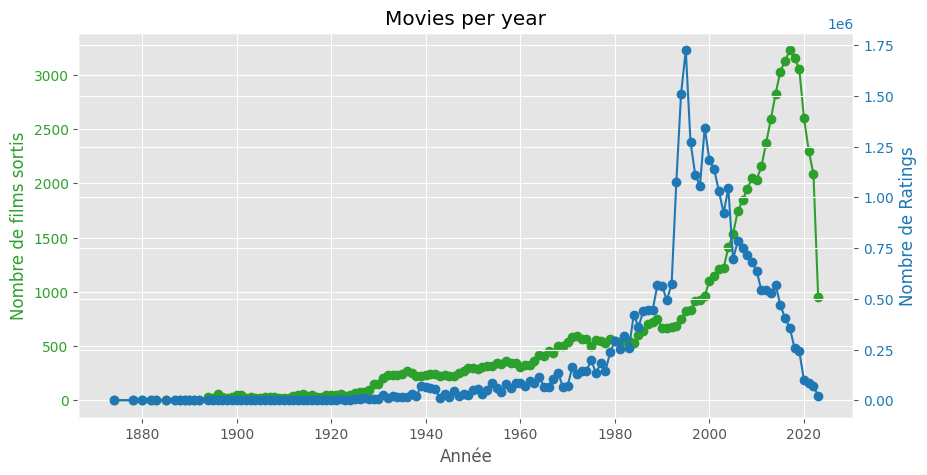

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:green'
ax1.set_xlabel('Année')
ax1.set_ylabel('Nombre de films sortis', color=color)
ax1.plot(merged['year'], merged['count'], color=color, marker="o")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Nombre de Ratings', color=color)
ax2.plot(merged['year'], merged['ratings_count'], color=color, marker="o")
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Movies per year")
plt.show()

Au fil des années, beaucoup plus de films sont sortis, et les utilisateurs donnent de plus en plus de notes. On note aussi une diminution du nombre de films sortis à partir de 2018, précédée vers 1990 d'une diminution d'avis sur les films (peut-être pas mis à jour).